## Plotting functions

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import scipy.stats as stats
from scipy.special import gamma
%matplotlib inline

In [2]:
class Params(object):
    def __init__(self, u=0.0, k=1.0, a=2.0, b=1.0):
        self.u = float(u)
        self.k = float(k)
        self.a = float(a)
        self.b = float(b)

    def __str__(self, precision=3):
        return 'u={u:-{l}.{p}f} k={k:-{l}.{p}f} a={a:-{l}.{p}f} b={b:-{l}.{p}f}'.format(u=self.u,
                                                         k=self.k,
                                                         a=self.a,
                                                         b=self.b,
                                                         p=precision,
                                                         l=precision+4)

In [3]:
class PPosterior(object):
    def __init__(self, params=Params()):
        self.params = params
        self.pdf_gamma = stats.gamma(a=params.a, scale=1/params.b)

    def pdf_scalar(self, u, l):
        pdf_norm = stats.norm(loc=self.params.u,
                              scale=(self.params.k*l)**(-0.5))
        return pdf_norm.pdf(u) * self.pdf_gamma.pdf(l)

    def pdf_list(self, u, l):
        return [[self.pdf_scalar(us, ls) for us in u] for ls in l]

    def pdf(self, u, l):
        if hasattr(u, '__iter__'):
            return self.pdf_list(u, l)
        else:
            return self.pdf_scalar(u, l)

    def mean(self):
        return np.array([self.params.u, self.params.a / self.params.b])

    def var(self):
        return np.array([self.params.b / (self.params.k * (self.params.a - 1)),
                         self.params.a / self.params.b**2])


In [4]:
class QPosterior(PPosterior):
    def __init__(self, params=Params()):
        self.params = params
        self.pdf_norm = stats.norm(loc=params.u, scale=(params.k)**(-0.5))
        self.pdf_gamma = stats.gamma(a=params.a, scale=1/params.b)

    def pdf_scalar(self, u, l):
        return self.pdf_norm.pdf(u) * self.pdf_gamma.pdf(l)


In [5]:
class InferResults(object):
    def __init__(self, p, loss):
        self.p = p
        self.loss = loss
        self.n = len(p)

    def __len__(self):
        return self.n

    def __str__(self, i=None):
        if i is None:
            return '\n'.join([self.__str__(j) for j in range(self.n)])
        else:
            return 'it={:-3d} loss={:10.5f} {:s}'.format(i, self.loss[i], self.p[i].__str__())

    def opt_index(self):
        return max(enumerate(self.loss[1:]), key=lambda x: x[1])[0] + 1

    def opt_params(self):
        return self.p[self.opt_index()]

    def __iter__(self):
        return InferResultsIterator(self)

    def __getitem__(self, i):
        return self.p[i]


In [6]:
class InferResultsIterator(object):
    def __init__(self, r):
        self.r = r
        self.i = 0

    def next(self):
        if self.i == self.r.n:
            raise StopIteration
        else:
            p = self.r.p[self.i]
            self.i += 1
            return p

In [8]:
def infer_pposterior(x, prior_params):
    # Calculate the exact parameter solution (for the P Posterior)
    # Refer to the equation (12) to (15) in my notes 
    n = len(x)
    x_mean = np.mean(x)
    x_var = np.sum((x - x_mean)**2)
    return Params(u=(n*x_mean+prior_params.k*prior_params.u)/(n+prior_params.k),
                  k=n+prior_params.k,
                  a=0.5*n+prior_params.a,
                  b=0.5*(x_var+(prior_params.k*n*(x_mean-prior_params.u)**2)/(prior_params.k+n)))

In [16]:
def infer_qposterior(x, pprior_params, init_params=Params(), maxit=100, eps=1e-10):
    # Calculate the appriximate solution of parameter (for the Q distribution)
    # Refer to the equation (25) to (30) in my notes 
    xs = sum(x)
    xss = sum(x**2)
    x_mean = np.mean(x)
    N = len(x)

    p_list = [init_params]
    l_list = [costs(init_params)]
    uc = (pprior_params.k * pprior_params.u + N * x_mean) / (pprior_params.k + N)
    ac = pprior_params.a + (N + 1) / 2.0
    it = 0
    while it < maxit:
        p_prev = p_list[it]
        eu = p_prev.u
        k_and_u = 1 / p_prev.k + p_prev.u**2
        p_next = Params(
            u=uc,
            k=(pprior_params.k + N) * p_prev.a / p_prev.b,
            a=ac,
            b=pprior_params.b + pprior_params.k * \
            (k_and_u + pprior_params.u**2 - 2 * eu * pprior_params.u) + \
            0.5 * (xss + N * k_and_u - 2 * eu * xs))
        p_list.append(p_next)
        l_list.append(costs(p_next))
        if abs(l_list[it + 1] - l_list[it]) < eps:
            break
        it += 1
    return InferResults(p_list, l_list)

In [9]:
def plot_a_posterior(posterior, axes, xlim=None, ylim=None, color='red'):
    if xlim is None or ylim is None:
        lower = posterior.mean() - 3 * posterior.var()
        upper = posterior.mean() + 3 * posterior.var()
        if xlim is None:
            xlim = [lower[0], upper[0]]
        if ylim is None:
            ylim = [lower[1], upper[1]]

    locs = np.linspace(xlim[0], xlim[1])
    scales = np.linspace(ylim[0], ylim[1])
    pp = posterior.pdf(locs, scales)
    axes.contour(locs, scales, pp, colors=color)
    axes.set_xlabel('$\mu$')
    axes.set_ylabel('$\lambda$')

In [10]:
def plot_infer_results(pposterior, qposterior, maxit=None, xlim=None, ylim=None):
    ncols = 3
    if maxit is None:
        nrows = int(np.ceil(float(opt_index) / ncols))
        maxit = nrows * ncols + 1
    else:
        nrows = int(np.ceil(float(maxit + 1) / ncols))
         
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols*5, nrows*5))
    axes = axes.flatten()
    for i in range(0, maxit + 1):
        plot_a_posterior(pposterior, axes[i], xlim, ylim, color='red')
        plot_a_posterior(qposterior[i], axes[i], xlim, ylim, color='green')
        axes[i].set_title('Iteration {:d}'.format(i))   

In [11]:
def costs(p):
    return -(0.5 * np.log(1.0 / p.k) + np.log(gamma(p.a)) - p.a * np.log(p.b))

In [12]:
def plot_costs(results):
    fig, axes = plt.subplots(figsize=(15, 5))
    line, = axes.plot(range(1, len(results)), results.loss[1:])
    line.set_linewidth(2)
    line.set_marker('s')
    line.set_markerfacecolor('red')
    line.set_color('blue')
    axes.set_xlabel('Iteration')
    axes.set_ylabel(r'$J(Q(\mu,\lambda))$')
    axes.set_xticks(range(1, len(results)))
    axes.grid()

In [13]:
def simulate(u=0.0, l=1.0, size=100):
    return np.random.normal(loc=u, scale=l**(-0.5), size=size)

## Setting 1

* Data $X$: $\mu=0.0$, $\lambda=1.0$, $N=10$
* Prior:
$E[\mu]=\mu_0=0 \quad \quad$$ Var[\mu]=\frac{b_0}{\kappa_0(a_0-1)} \quad \quad$
$E[\lambda]=\frac{a_0}{b_0}=1.0 \quad \quad $$Var[\lambda]=\frac{a_0}{b_0^2}$


it=  0 loss=  -0.00000 u=  0.000 k=  1.000 a=  2.000 b=  1.000
it=  1 loss=  11.86284 u=  0.671 k= 22.000 a=  5.501 b= 13.401
it=  2 loss=   6.09419 u=  0.671 k=  4.516 a=  5.501 b=  5.423
it=  3 loss=   7.52535 u=  0.671 k= 11.159 a=  5.501 b=  6.479
it=  4 loss=   6.72001 u=  0.671 k=  9.340 a=  5.501 b=  5.688
it=  5 loss=   6.88547 u=  0.671 k= 10.639 a=  5.501 b=  5.792
it=  6 loss=   6.80135 u=  0.671 k= 10.447 a=  5.501 b=  5.714
it=  7 loss=   6.81815 u=  0.671 k= 10.590 a=  5.501 b=  5.724
it=  8 loss=   6.80977 u=  0.671 k= 10.571 a=  5.501 b=  5.716
it=  9 loss=   6.81144 u=  0.671 k= 10.585 a=  5.501 b=  5.717
it= 10 loss=   6.81060 u=  0.671 k= 10.584 a=  5.501 b=  5.717
Approx parameters for Q: 
 u=  0.671 k= 10.584 a=  5.501 b=  5.717
True exact parameters for P: 
 u=  0.671 k= 11.000 a=  5.001 b=  4.924


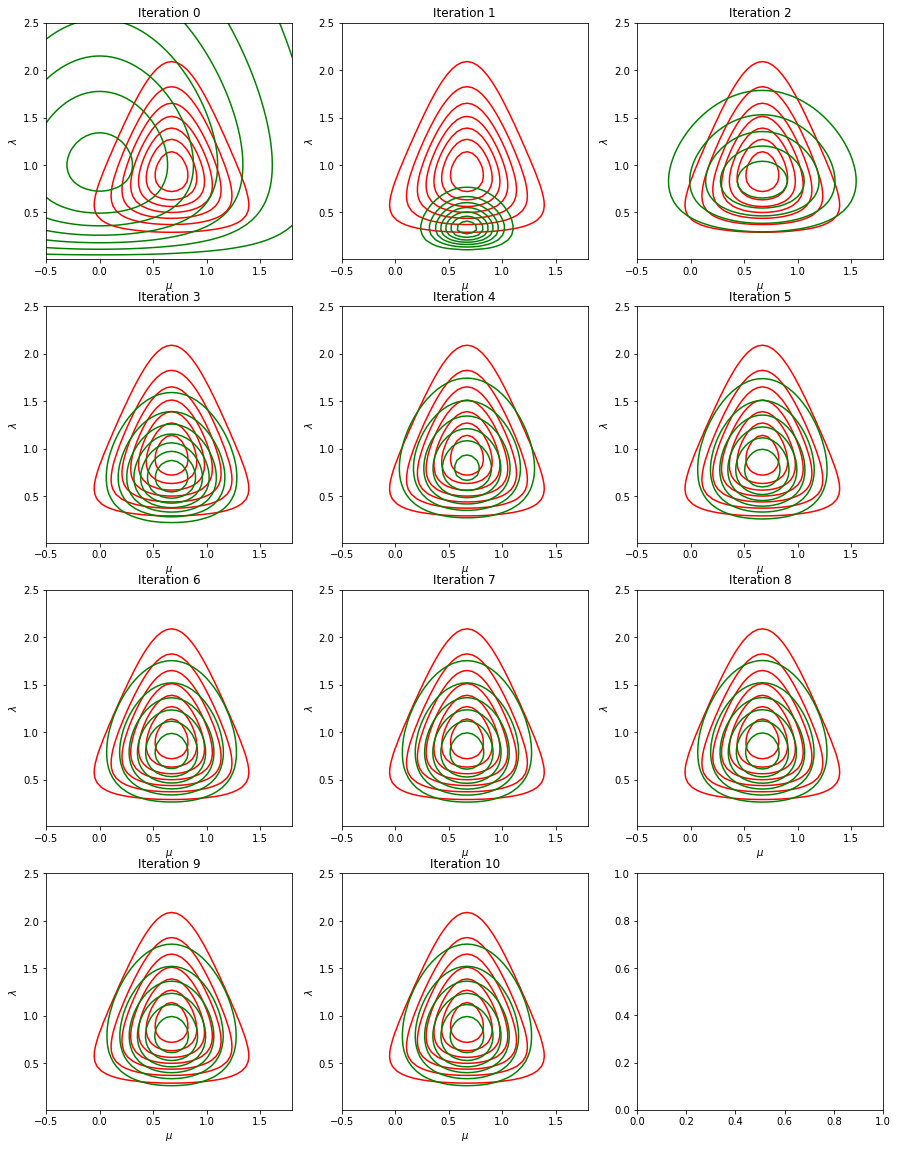

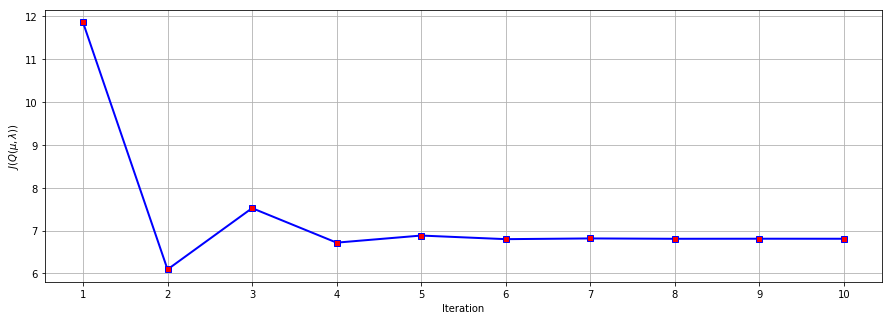

In [17]:
np.random.seed(0)
# 10 points sampled from N(miu=0.0, lambda=1.0)
x = simulate(u=0.0, l=1.0, size=10)
max_iteration = 10

pprior_params = Params(u=0.0, k=1.0, a=0.001, b=0.001)
# Return the exact solution of P Posterior
pposterior_params = infer_pposterior(x, pprior_params)
pposterior = PPosterior(pposterior_params)

init = Params(u=0.0, k=1.0, a=2.0, b=1.0)
qposterior_infer_results = infer_qposterior(x, pprior_params, init, maxit=max_iteration)
qposterior = []
for i in range(qposterior_infer_results.n):
    qposterior.append(QPosterior(qposterior_infer_results[i]))

plot_infer_results(pposterior, qposterior, maxit=max_iteration, xlim=[-0.5, 1.8], ylim=[0.01, 2.5])
plot_costs(qposterior_infer_results)
print(qposterior_infer_results)
print("Approx parameters for Q: \n", qposterior_infer_results[max_iteration])
print("True exact parameters for P: \n", pposterior_params)

## Setting 2

* Same as setting 1, but $N=100$ instead of $N=10$
* Data $X$: $\mu=0.0$, $\lambda=1.0$, $N=100$
* Prior:
$E[\mu]=\mu_0=0 \quad \quad$$ Var[\mu]=\frac{b_0}{\kappa_0(a_0-1)} \quad \quad$
$E[\lambda]=\frac{a_0}{b_0}=1.0 \quad \quad $$Var[\lambda]=\frac{a_0}{b_0^2}$


it=  0 loss=   1.38629 u=  0.000 k=  1.000 a=  2.000 b=  2.000
it=  1 loss=  89.45543 u=  0.059 k=101.000 a= 50.600 b=102.070
it=  2 loss=  54.39165 u=  0.059 k= 50.069 a= 50.600 b= 51.400
it=  3 loss=  55.23779 u=  0.059 k= 99.428 a= 50.600 b= 51.913
it=  4 loss=  54.73754 u=  0.059 k= 98.445 a= 50.600 b= 51.408
it=  5 loss=  54.74748 u=  0.059 k= 99.413 a= 50.600 b= 51.413
it=  6 loss=  54.74247 u=  0.059 k= 99.403 a= 50.600 b= 51.408
it=  7 loss=  54.74257 u=  0.059 k= 99.413 a= 50.600 b= 51.408
it=  8 loss=  54.74252 u=  0.059 k= 99.413 a= 50.600 b= 51.408
it=  9 loss=  54.74252 u=  0.059 k= 99.413 a= 50.600 b= 51.408
it= 10 loss=  54.74252 u=  0.059 k= 99.413 a= 50.600 b= 51.408
Approx parameters for Q: 
 u=  0.059 k= 99.413 a= 50.600 b= 51.408
True exact parameters for P: 
 u=  0.059 k=101.000 a= 50.100 b= 50.793


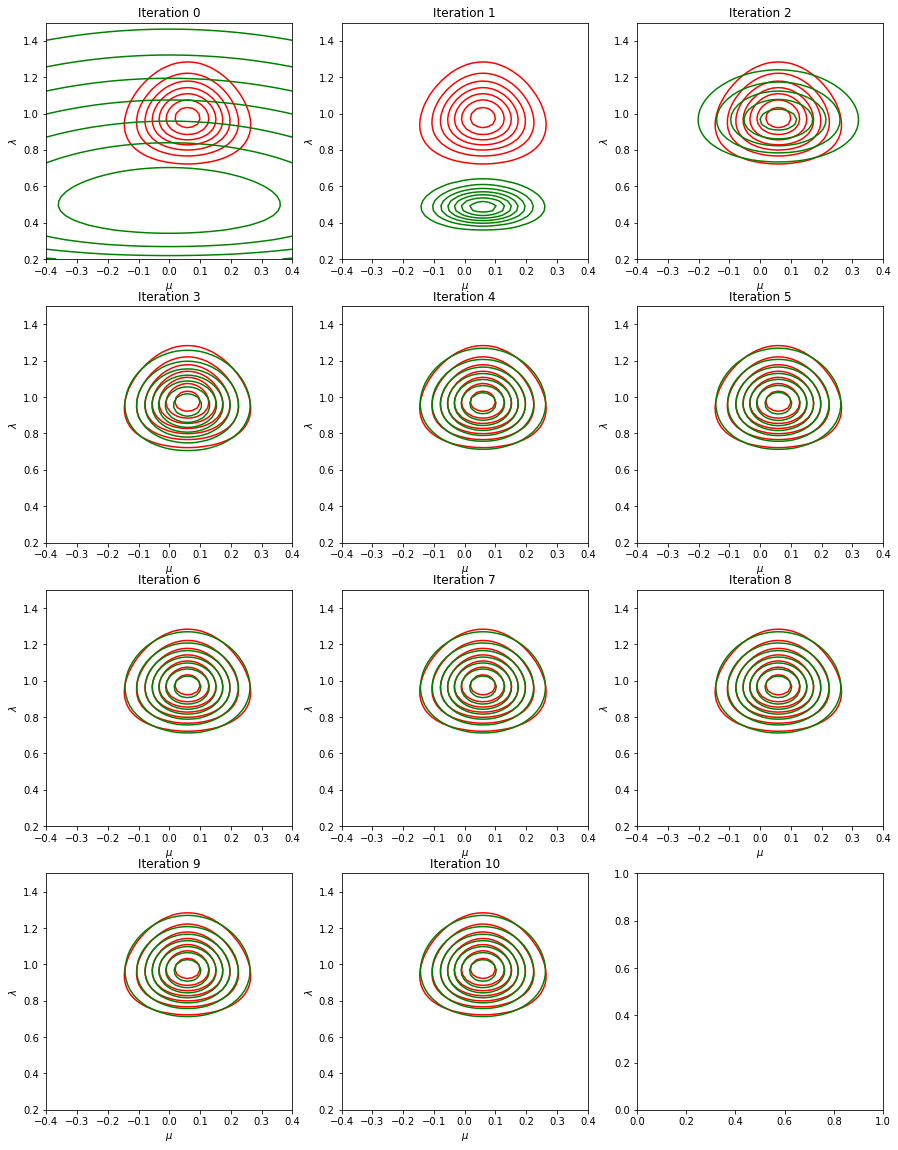

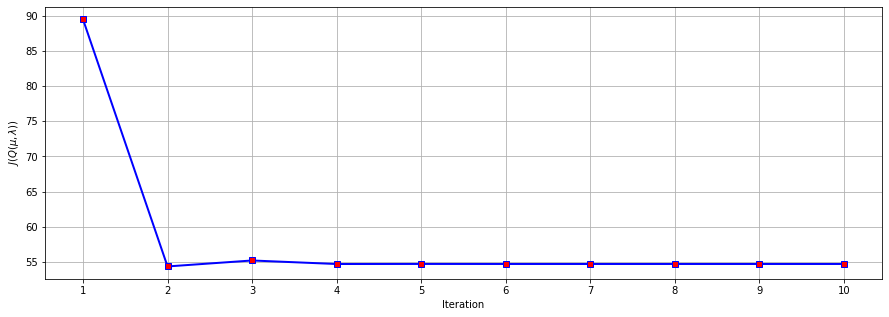

In [112]:
np.random.seed(0)
# 100 points sampled from N(miu=0.0, lambda=1.0)
x = simulate(u=0.0, l=1.0, size=100)
max_iteration = 10

pprior_params = Params(u=0.0, k=1.0, a=0.1, b=0.1)
pposterior_params = infer_pposterior(x, pprior_params)
pposterior = PPosterior(pposterior_params)

init = Params(u=0.0, k=1.0, a=2.0, b=2.0)
qposterior_infer_results = infer_qposterior(x, pprior_params, init, maxit=max_iteration)
qposterior = []
for i in range(qposterior_infer_results.n):
    qposterior.append(QPosterior(qposterior_infer_results[i]))

plot_infer_results(pposterior, qposterior, maxit=max_iteration, xlim=[-0.4, 0.4], ylim=[0.2, 1.5])
plot_costs(qposterior_infer_results)
print(qposterior_infer_results)
print("Approx parameters for Q: \n", qposterior_infer_results[max_iteration])
print("True exact parameters for P: \n", pposterior_params)